## Quick and Dirty CoM Analysis

In [1]:
import numpy as np
import h5py
import hdf5plugin
import os
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from matplotlib.ticker import FormatStrFormatter
import os

%matplotlib inline

In [2]:
 def wrapTo2pi(x):
    """
    Python implementation of Matlab method `wrapTo2pi`.
    Wraps angles in x, in radians, to the interval [0, 2*pi] such that 0 maps
    to 0 and 2*pi maps to 2*pi. In general, positive multiples of 2*pi map to
    2*pi and negative multiples of 2*pi map to 0.
    """
    xwrap = np.remainder(x - np.pi, 2 * np.pi)
    mask = np.abs(xwrap) > np.pi
    xwrap[mask] -= 2 * np.pi * np.sign(xwrap[mask])
    return xwrap + np.pi

In [7]:
# Constants
#experimentPath = '/data/visitor/ma4442/id03/20240625/RAW_DATA'
#sample = '/111-sample-4'
#dataset ='_less_coarse_mosa'

experimentPath = '/data/visitor/hc5803/id03/20241105/RAW_DATA'
sample = '/110_5pct'
dataset = '_111_mosa_layers_chi_diffrz'


motor_phi = 'diffrz'#'diffrz'
motor_chi = 'chi'
    
datasetAbsPath = experimentPath + sample + sample + dataset
datasetH5File = sample + dataset + '.h5'
datasetH5FileAbsPath = datasetAbsPath + datasetH5File

# define scan id
scanID = 1

print('dataset folder contains:')
print(os.listdir(datasetAbsPath))

print('searching for:')
print(datasetH5FileAbsPath)
if os.path.isfile(datasetH5FileAbsPath):
    print('h5 file could be found')
else: print('ERROR! h5 file does not exist!!')
    


dataset folder contains:
['scan0002', 'scan0005', 'scan0016', 'scan0019', 'scan0007', 'scan0009', 'scan0020', 'scan0023', 'scan0011', 'scan0022', 'scan0013', 'scan0001', 'scan0004', 'scan0015', 'scan0018', 'scan0006', 'scan0008', 'scan0010', 'scan0021', 'scan0024', 'scan0012', '110_5pct_111_mosa_layers_chi_diffrz.h5', 'scan0003', 'scan0014', 'scan0017']
searching for:
/data/visitor/hc5803/id03/20241105/RAW_DATA/110_5pct/110_5pct_111_mosa_layers_chi_diffrz/110_5pct_111_mosa_layers_chi_diffrz.h5
h5 file could be found


### Read in H5Data

In [8]:
#open h5 file
with h5py.File(datasetH5FileAbsPath, 'r') as h5f:
    # go to scan id
    scanIdString = str(scanID)+".1"
    h5scan = h5f[scanIdString]
    # load phi and chi
    chish5 = np.array(h5scan['instrument'][motor_chi]['value'])
    phish5 = np.array(h5scan['instrument'][motor_phi]['data'])


In [9]:
chis = np.unique(np.round(chish5, 2))
phis = np.unique(np.round(phish5, 2))

In [10]:
#open h5 file
with h5py.File(datasetH5FileAbsPath, 'r') as h5f:
    # go to scan id
    scanIdString = str(scanID)+".1"
    h5scan = h5f[scanIdString]
    # load pco_ff data
    chi_phi_framestack = h5scan['instrument']['pco_ff']['image'][:,:,:]


### Flip Axes and rearrange array to [chi, phi, x, y]

In [11]:

print('data shape is: '+str(chi_phi_framestack.shape))
print(13700, 100*165)
#reshuffleImage to phi and chi.
chi_phi_framestack = chi_phi_framestack.reshape((len(chis),len(phis),2048,2048))
print(chi_phi_framestack.shape)

#axs[0,1].imshow(pco_ffDataReshaped[0,-1,:,:])
#axs[1,1].imshow(pco_ffDataReshaped[1,0,:,:])


data shape is: (2666, 2048, 2048)
13700 16500
(62, 43, 2048, 2048)


### Do some basic Background Substraction

In [12]:
# converto float
#pco_ffDataReshaped = pco_ffDataReshaped.astype(np.float32)
backgroundValue = 105
chi_phi_framestack.clip(backgroundValue, None, out=chi_phi_framestack)
chi_phi_framestack-=backgroundValue
print('done')
#mask = np.zeros_like(pco_ffDataReshaped)
#pco_ffDataReshaped -= backgroundValue
#imageThreshold = np.maximum(pco_ffDataReshaped, mask)
#del pco_ffDataReshaped


done


### CoM identification

In [13]:
totalIntensity = np.sum(chi_phi_framestack, axis=(0,1), dtype=np.float32 )
minIntensity = 1e-4
totalIntensity.clip(minIntensity, None, out=totalIntensity)

comChi = np.sum((np.sum(chi_phi_framestack, axis = 1)*chis[:,np.newaxis,np.newaxis]), axis = 0)/totalIntensity
comPhi = np.sum((np.sum(chi_phi_framestack, axis = 0)*phis[:,np.newaxis,np.newaxis]), axis = 0)/totalIntensity

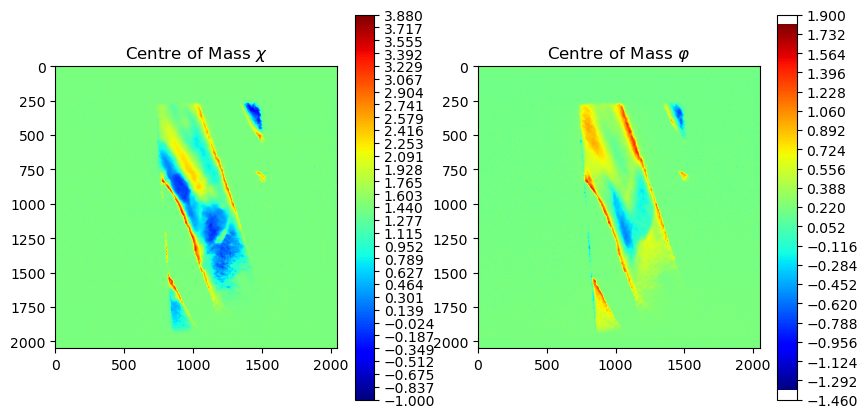

In [14]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))
d1 = axs[0].imshow(comChi, vmin = chis[0], vmax = chis[-1], cmap = "jet")
axs[0].set_title(r'Centre of Mass $\chi$')
d2 = axs[1].imshow(comPhi, vmin = phis[1], vmax = phis[-2], cmap = "jet")
axs[1].set_title(r'Centre of Mass $\varphi$')
cbar1 = fig.colorbar(d1, ax=axs[0])
cbar1.set_ticks(np.linspace(chis[0],chis[-1],len(chis) // 2))
cbar2 = fig.colorbar(d2, ax=axs[1])
cbar2.set_ticks(np.linspace(phis[0],phis[-1],len(phis) // 2))

### Mosaicity

In [15]:
 # Generate Color Map
phisMap = np.linspace(-1, 1, 400) 
chisMap = np.linspace(-1, 1, 400)
meshgrid = np.meshgrid(phisMap, chisMap)
angles = np.arctan2(-meshgrid[0], -meshgrid[1])
anlgesNormalized = wrapTo2pi(angles) / np.pi / 2
sqr = np.sqrt(np.power(meshgrid[0], 2) + np.power(meshgrid[1], 2)) / np.sqrt(2)

hsv_key = np.stack(
    (
        anlgesNormalized,
        sqr,
        np.ones(anlgesNormalized.shape),
    ),
    axis=2)
colormap = hsv_to_rgb(hsv_key)


# Calculate Mosa Image
chiNorm = (comChi - np.amin(chis)) / ((np.ptp(chis))) - 0.5
phiNorm = (comPhi - np.amin(phis)) / ((np.ptp(phis))) - 0.5

print(np.min(chiNorm, axis = (0,1)))
print(np.max(phiNorm, axis = (0,1)))

mosAngle = np.arctan2(-chiNorm,-phiNorm)
normalizedAngle = wrapTo2pi(mosAngle) / np.pi / 2
sqr = np.sqrt(np.power(chiNorm, 2) + np.power(chiNorm, 2)) / np.sqrt(2)

hsv_key = np.stack(
    (
        normalizedAngle,
        sqr,
        np.ones(chiNorm.shape),
    ),
    axis=2)
mosa = hsv_to_rgb(hsv_key)

-0.4785984778398648
0.5


In [16]:
print(hsv_key.shape)
print(np.min(hsv_key, axis = (0,1)))
print(np.max(hsv_key, axis = (0,1)))

(2048, 2048, 3)
[1.41357986e-16 0.00000000e+00 1.00000000e+00]
[1.  0.5 1. ]


[Text(0, 0.0, '-1.460'),
 Text(0, 99.75, '-0.620'),
 Text(0, 199.5, '0.220'),
 Text(0, 299.25, '1.060'),
 Text(0, 399.0, '1.900')]

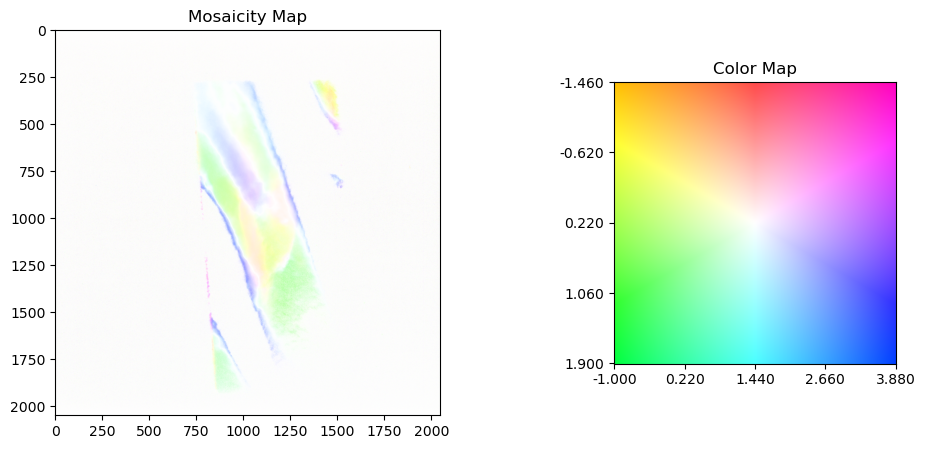

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5),gridspec_kw={'width_ratios': [2,1]})
d0 = axs[0].imshow(mosa) # phi
axs[0].set_title(r"Mosaicity Map")

d1 = axs[1].imshow(colormap)
axs[1].set_title(r"Color Map")
chiTicks = np.linspace(0, colormap.shape[1]-1,5)
chiLabel = np.linspace(chis[0], chis[-1], 5)
chiLabel = np.round(chiLabel, decimals=3)
chiLabel = np.array([f'{chi:.3f}' for chi in chiLabel])
axs[1].set_xticks(chiTicks)
axs[1].set_xticklabels(chiLabel)

phiTicks = np.linspace(0, colormap.shape[1]-1,5)
phiLabel = np.linspace(phis[0], phis[-1], 5)
phiLabel = np.round(phiLabel, decimals=3)
phiLabel = np.array([f'{phi:.3f}' for phi in phiLabel])

axs[1].set_yticks(phiTicks)
axs[1].set_yticklabels(phiLabel)

In [18]:
mem = 0
for var in dir():
    thevar = globals()[var]
    if isinstance(thevar, np.ndarray):
        mem += thevar.nbytes
        print(var, thevar.nbytes / 1e9, 'GB')
mem / 1e9

angles 0.00128 GB
anlgesNormalized 0.00128 GB
axs 1.6e-08 GB
chiLabel 1.2e-07 GB
chiNorm 0.033554432 GB
chiTicks 4e-08 GB
chi_phi_framestack 22.364028928 GB
chis 4.96e-07 GB
chisMap 3.2e-06 GB
chish5 2.1328e-05 GB
colormap 0.00384 GB
comChi 0.033554432 GB
comPhi 0.033554432 GB
hsv_key 0.100663296 GB
mosAngle 0.033554432 GB
mosa 0.100663296 GB
normalizedAngle 0.033554432 GB
phiLabel 1.2e-07 GB
phiNorm 0.033554432 GB
phiTicks 4e-08 GB
phis 3.44e-07 GB
phisMap 3.2e-06 GB
phish5 2.1328e-05 GB
sqr 0.033554432 GB
totalIntensity 0.016777216 GB


22.823463992